# Meta-analysis and variance-components 

<br />
### Prof. Manuel A. Rivas (<a href="rivaslab.stanford.edu">rivaslab.stanford.edu</a>)
#### Topics in Biomedical Data Science : Large-scale inference 
#### Lecture number 3
#### 04/11/2017

<img src="https://identity.stanford.edu/overview/images/signature/stanford-university.png" alt="Stanford University" style="width: 400px;" align="right"/>

# Motivating examples for today 

* Dissecting the genetics of complex traits using summary association statistics 
* Heritability in the genomics era

<center>
![metaanalysis](https://www.dropbox.com/s/nlg18h150a5ws0m/summary_stats.png?dl=1 "Source: Basaniuc and Price, 2017 Nature Reviews Genetics")
</center>

In human genetics summary statistics have been used for combining evidence for a particular variant across studies.


<center>
![heritability](https://www.dropbox.com/s/9z2na0w427ibgxn/heritability.png?dl=1 "Source: Visscher, Hill & Wray, 2008 Nature Reviews Genetics")
</center>

<pre></pre>

A standard way of estimating heritabilityof a trait is by regressing the phenotype of the offspring on the average phenotype of the parents.

In [3]:
library(rstan)
options(warn=-1)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.12.1, packaged: 2016-09-11 13:07:50 UTC, GitRev: 85f7a56811da)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


# Hierarchical meta-analysis model 

Stan is a probabilistic programming language for statistical inference. It can be used for statistical modeling across a variety of domains.

In this section, we will explore some of the examples, available online that can be extended to datasets that are being organized in biomedicine. In the problem sets you will be asked to run some of the statistical models presented in the lecture notes.

First, we begin with the hierarchical meta-analysis model described in section 5.5 of Gelman et al. (2003)[1] and described in the RStan vignette (https://cran.r-project.org/web/packages/rstan/vignettes/rstan.html).

In this example they focus on the *Eight Schools* dataset. The aim of the exercise is to apply a hierarchical model to model the effect of coaching programs on college admissions tests. 

### Preparation of dataset

The dataset available consists of indicators for each School, $j$, estimated effect, $\hat{\beta}_j$, and standard error $\sigma_j$. 

A table is provided: 


|School|Estimate ($\hat{\beta}_j$)	|Standard Error ($\sigma_j$)|
|----------|
|A|28|15|
|B|8	|10|
|C|-3	|16|
|D|7	|11|
|E|-1	|9|
|F|1	|11|
|G|18	|10|
|H|12	|18|



As noted by the authors, this is an interesting example in studying the underlying parameters because it addresses: 

1) the effects of coaching in each of the eight schools, and 

2) the hyperparameter representing the variation of these effects in the modeled population. 

+ In a genetic association study this may be of immediate relevance when trying to identify variants with heterogeneous genetic effects across populations, for instance. 

+ See "Binary effects assumption" from Interpreting Meta-Analyses of Genome-Wide Association Studies from Han and Eskin(2012) http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1002555.

The statistical model specified is:

<center>
$\hat{\beta_j} \sim \mathcal{N}\left(\beta_{j},\sigma_j\right), j=1,\dots,8; \\
\beta_j \sim \mathcal{N}\left(\mu,\tau\right), j=1,\dots,8; \\
p\left(\mu,\tau\right) \propto 1.$
</center>

where each $\sigma_j$ is assumed known.

We will write a Stan program, that RStan will access, to be coded in a text file. We put the following code for the Eight Schools model into the file `schools.stan` (see Notes).

## Specify the data 

```
data { 
  int<lower=0> J;      // number of schools 
  real betahat[J]; // estimated treatment effects
real<lower=0> sigma[J]; //standard error of effect estimates 
}
```

The data block, specifies the data that is conditioned upon in Bayes Rule: the number of schools, $J$, the vector of estimates, $(\hat{\beta}_1\dots,\hat{\beta}_J)$, and the vector of standard errors of the estimates $(\sigma_1, \dots, \sigma_j)$.


## Specify the parameters

```
parameters {
  real mu; 
  real<lower=0> tau;
  vector[J] eta;
}
```
The parameters block declares the parameters whose posterior distribution is sought. These are the the mean, $\mu$, and standard deviation, $\tau$, of the school effects, plus the standardized school-level effects $\eta$, which will be used to obtain $\beta$ (for sampling purpose).

## Transformed parameters 

<pre>
transformed parameters {
  vector[J] beta;
  beta = mu + tau * eta;
}
</pre>


## Model 

```
model {
  target += normal_lpdf(eta | 0, 1);
  target += normal_lpdf(betahat | beta, sigma);
}
```

Evaluate the target density from which the sampler samples.

We prepare the data in R using lists:

In [1]:

schools_data <- list(
  J = 8,
  betahat = c(28,  8, -3,  7, -1,  1, 18, 12),
  sigma = c(15, 10, 16, 11,  9, 11, 10, 18)
)

Next, we call RStan to draw posterior samples: 

In [32]:
options(warn=-1)
library(rstan)
fit1 <- stan(
  file = "schools.stan",  # Stan program
  data = schools_data,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )


### Summary of the parameters

In [33]:
print(fit1, pars=c("beta", "mu", "tau", "lp__"), probs=c(.1,.5,.9))

Inference for Stan model: schools.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd    10%    50%    90% n_eff Rhat
beta[1]  11.40    0.16 8.14   2.59  10.27  22.11  2471    1
beta[2]   8.00    0.10 6.14   0.71   7.95  15.16  3596    1
beta[3]   6.18    0.14 7.76  -3.25   6.81  14.82  2869    1
beta[4]   7.55    0.10 6.33  -0.02   7.53  15.21  3734    1
beta[5]   5.15    0.10 6.14  -2.87   5.64  12.45  4000    1
beta[6]   6.08    0.12 6.48  -2.05   6.46  13.71  3141    1
beta[7]  10.76    0.13 6.80   2.90  10.06  19.62  2895    1
beta[8]   8.63    0.14 7.78  -0.19   8.48  17.72  3056    1
mu        8.02    0.12 4.88   2.05   7.97  13.93  1761    1
tau       6.57    0.14 5.21   1.06   5.36  13.43  1457    1
lp__    -39.31    0.07 2.55 -42.67 -39.02 -36.26  1360    1

Samples were drawn using NUTS(diag_e) at Mon Apr 10 21:58:52 2017.
For each parameter, n_eff is a crude measure of effective s

From our run of the dataset we can see that mean estimate of beta corresponds to $8.02$ with estimate of $\tau$, variation of the effects, estimated at $6.57$. 

We can use the plotting functionality in RStan to visualize the parameters estimated:

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


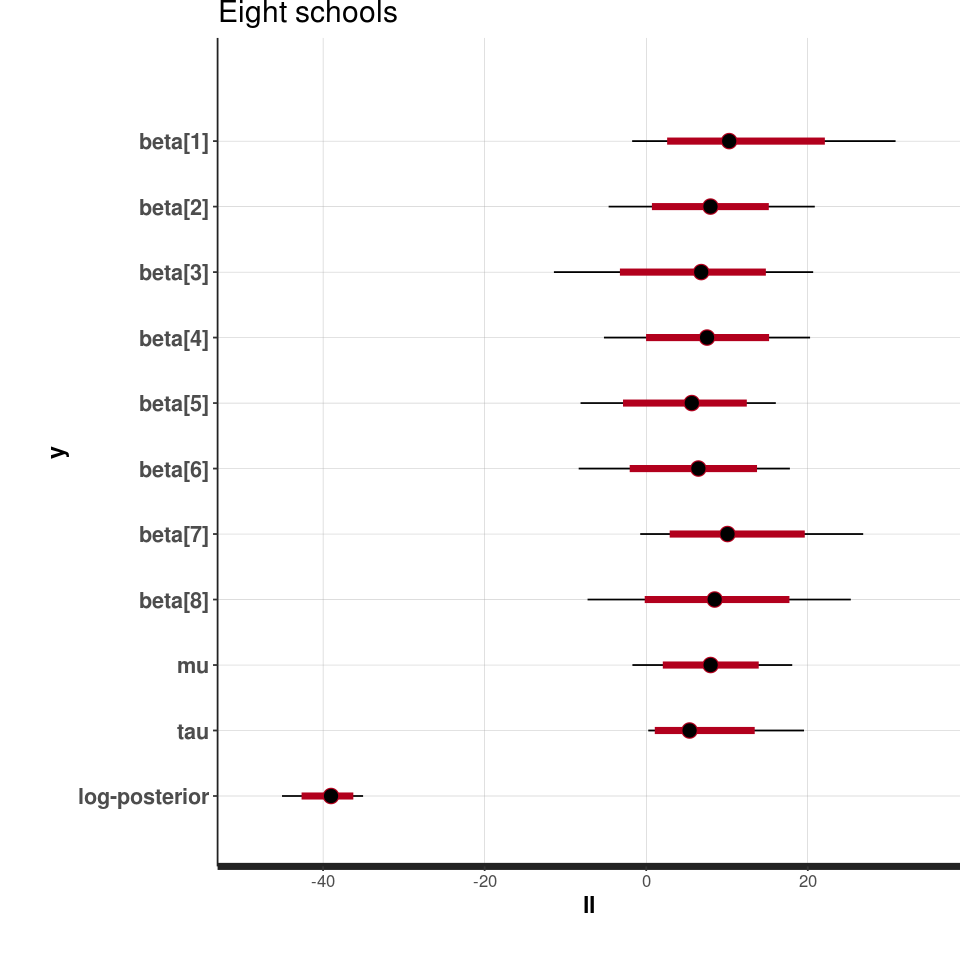

In [34]:
options(warn=-1)
options(repr.plot.width=8, repr.plot.height=8)
plot(fit1, pars=c("beta", "mu", "tau", face="bold"))

The `traceplot` method is used to plot the time series of the posterior draws. If we include the warmup draws by setting `inc_warmup=TRUE`, the background color of the warmup area is different from the post-warmup phase:

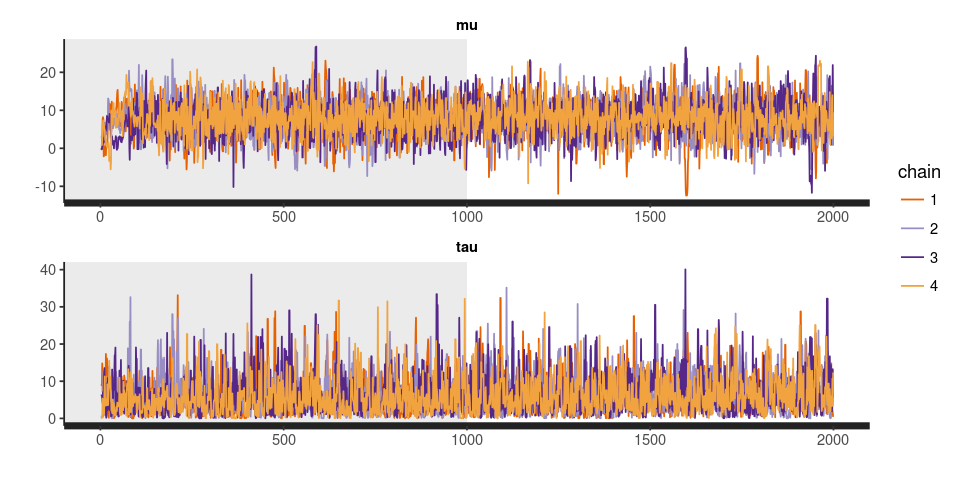

In [37]:
options(repr.plot.width=8, repr.plot.height=4)
traceplot(fit1, pars = c("mu", "tau"), inc_warmup = TRUE, nrow = 2)

To assess convergence of Markov Chains Gelman et al. propose the $\hat{R}$ statistic, which is presented in Rstan summary. 

In [38]:
print(fit1, pars = c("mu", "tau"))

Inference for Stan model: schools.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

    mean se_mean   sd  2.5% 25%  50%   75% 97.5% n_eff Rhat
mu  8.02    0.12 4.88 -1.71 5.0 7.97 11.06 18.07  1761    1
tau 6.57    0.14 5.21  0.25 2.6 5.36  9.39 19.53  1457    1

Samples were drawn using NUTS(diag_e) at Mon Apr 10 21:58:52 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


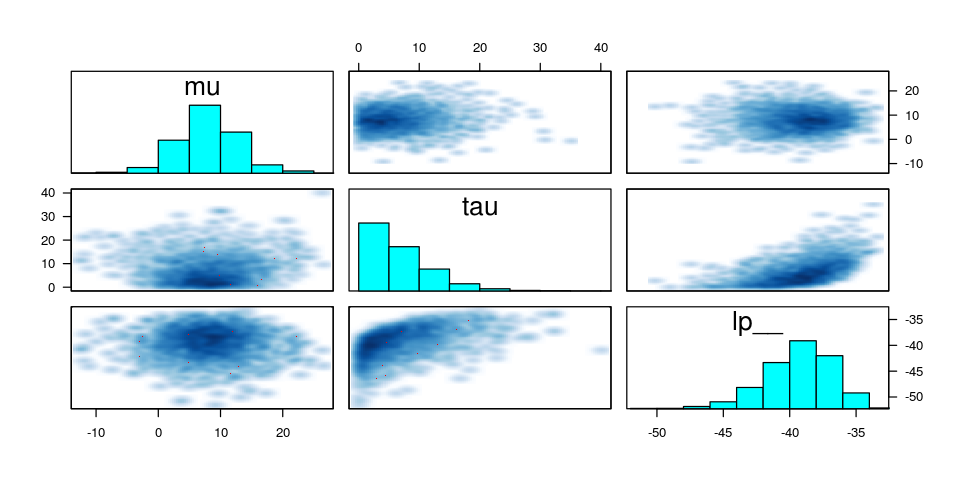

In [39]:
options(repr.plot.width=8, repr.plot.height=4)
pairs(fit1, pars = c("mu", "tau", "lp__"), las = 1)

The below-diagonal intersection and the above-diagonal intersection of the same two variables should have distributions that are mirror images of each other. Any yellow points would indicate transitions where the maximum `treedepth__` was hit, and red points indicate a divergent transition.

## Application to Genetic data

Majumdar et al. present a nice approach for the meta-analysis of multiple phenotypes in genome-wide association studies *An efficient Bayesian meta-analysis approach for studying cross-phenotype genetic associations*, Biorxiv 2017 (http://biorxiv.org/content/early/2017/01/18/101543).

We use some of the summary statistic data to study the behavior of the hierarchical meta-analysis model in STAN. 

In [22]:
library("CPBayes")
# Load Beta Hat
BetaHatfile <- load("CPBayes/inst/extdata/BetaHat.rda")
BetaHat

[1]  0.03402285 -0.01987781 -0.01088476 -0.00940975  0.02195188 -0.01728955
 [7]  0.14180403  0.06979527 -0.11721340 -0.09231879

In [23]:
SEfile <- load("CPBayes/inst/extdata/SE.rda")
SE

[1] 0.02736746 0.02741876 0.02749038 0.02747637 0.02749800 0.02753650
 [7] 0.02731022 0.02714103 0.02786046 0.02783711

In [24]:
# Specify the name of the studies and the genetic variant.
studyNames <- paste("Study", 1:10, sep = "")
SNP1 <- "rs1234"

Revisit organization of the *Eight schools* dataset. 

In [25]:
genetic_data <- list(
  J = 10,
  betahat = BetaHat,
  sigma = SE
)

The model we will use is similar to the *Eight schools* model: 

<center>
$\hat{\beta_j} \sim \mathcal{N}\left(\beta_{j},\sigma_j\right), j=1,\dots,10; \\
\beta_j \sim \mathcal{N}\left(\mu,\tau\right), j=1,\dots,10; \\
p\left(\mu,\tau\right) \propto 1.$
</center>

Next, we call RStan: 

In [26]:
library(rstan)
fit2 <- stan(
  file = "genetic.stan",  # Stan program
  data = genetic_data,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )

### Summary of the parameters 

In [28]:
print(fit2, pars=c("beta", "mu", "tau", "lp__"), probs=c(.1,.5,.9))

Inference for Stan model: genetic.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean   sd   10%   50%   90% n_eff Rhat
beta[1]   0.03    0.00 0.03  0.00  0.03  0.06  4000 1.00
beta[2]  -0.02    0.00 0.03 -0.05 -0.02  0.02  4000 1.00
beta[3]  -0.01    0.00 0.03 -0.04 -0.01  0.02  4000 1.00
beta[4]  -0.01    0.00 0.03 -0.04 -0.01  0.02  4000 1.00
beta[5]   0.02    0.00 0.03 -0.01  0.02  0.05  4000 1.00
beta[6]  -0.02    0.00 0.03 -0.05 -0.02  0.02  4000 1.00
beta[7]   0.12    0.00 0.03  0.09  0.12  0.16  4000 1.00
beta[8]   0.06    0.00 0.03  0.03  0.06  0.09  4000 1.00
beta[9]  -0.10    0.00 0.03 -0.14 -0.10 -0.07  4000 1.00
beta[10] -0.08    0.00 0.03 -0.11 -0.08 -0.05  4000 1.00
mu        0.00    0.00 0.03 -0.03  0.00  0.03   700 1.00
tau       0.08    0.00 0.03  0.05  0.08  0.11   682 1.01
lp__      5.44    0.11 3.30  1.09  5.84  9.44   845 1.01

Samples were drawn using NUTS(diag_e) at Mon Apr

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


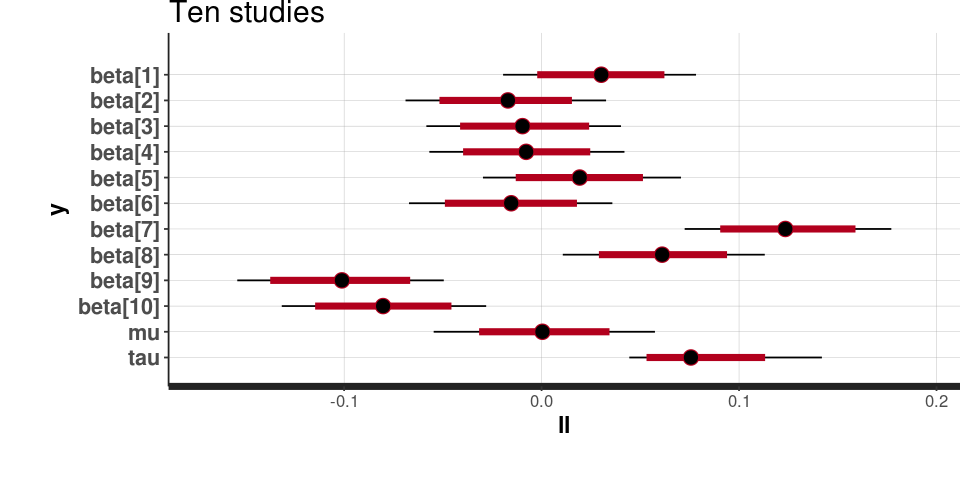

In [30]:
options(repr.plot.width=8, repr.plot.height=4)
plot(fit2, pars=c("beta", "mu", "tau")) + ggtitle("Ten studies") + theme(plot.margin = unit(c(0,0,1,1), "cm")) + theme(axis.text=element_text(size=10),
        axis.title=element_text(size=14,face="bold"))

# Variance components analysis

## Before we dive into variance-component analysis, let's revisit some history 

The BUGS (Bayesian inference Using Gibbs Sampling) project is concerned with flexible software for the Bayesian analysis of complex statistical models using Markov chain Monte Carlo (MCMC) methods. The project began in 1989 in the MRC Biostatistics Unit, Cambridge, and led initially to the "Classic" BUGS program, and then onto the WinBUGS software developed jointly with the Imperial College School of Medicine at St Mary’s, London (https://www.mrc-bsu.cam.ac.uk/software/bugs/). 

According to Google Scholar BUGS has 1295 citations (March 27, 2017). 

Meanwhile, WinBUGS has 4233 citations (March 27, 2017). It is quite possible these numbers do not represent the popularity of BUGS, but it gives an indication of the adoption in the statistical modeling community. 

Nonetheless, in comparison, PLINK (Purcell et al. 2007) has 12145 citations. 

The human genetics community has been quite active in the past decade. There have been two schools of statistical thought separating advances in application of statistical inference to human genetic data. 

Personally, I’ve been more of a hybrid: Bayesian-frequentist (NB: order does not indicate preference).

### BUGS Example 
Box and Tiao (1973) analyse data first presented by Davies (1967) concerning batch to batch
variation in yields of dyestuff. The data arise from a balanced experiment whereby
the total product yield was determined for 5 samples from each of 6 randomly chosen batches of
raw material.

|Batch |Yield (in grams)|
|-----------------------------|
|1 | 1545 1440 1440 1520 1580|
|2 | 1540 1555 1490 1560 1495|
|3 | 1595 1550 1605 1510 1560|
|4 | 1445 1440 1595 1465 1545|
|5 | 1595 1630 1515 1635 1625|
|6 | 1520 1455 1450 1480 1445|

The object of the study was to determine the relative importance of between batch variation
versus variation due to sampling and analytic errors. On the assumption that the batches and
samples vary independently, and contribute additively to the total error variance, we may assume
the following model for dyestuff yield:

<center>
$y_{ij} \sim \mathcal{N}\left(\mu_i, \tau_{\textrm{within}}\right) \\ 
\mu_{i} \sim \mathcal{N}\left(\theta, \tau_{\textrm{between}}\right)
$
</center>


where 
* $y_{ij}$ is the yield for sample $j$ of batch $i$, 
* $\mu_{i}$ is the true yield for batch $i$, 
* $\tau_{\textrm{within}}$ is the inverse of the within-batch variance $\sigma^2$ within (the variation due to sampling and analytic error), 
* $\theta$ is the true average yield for all batches and $\tau_{\textrm{between}}$ is the inverse of the between-batch variance $s^2_{\textrm{between}}$.

The total variation in product yield is thus $\sigma^2_{\textrm{total}} = \sigma^2_{\textrm{within}} + \sigma^2_{\textrm{between}}$ and the relative contributions of each component to the total variance.

The relative contribution to the total variance for each component is 
* $f_{\textrm{within}} = \sigma^2_{\textrm{within}}/\sigma^2_{\textrm{total}}$, and 
* $f_{\textrm{between}} = \sigma^2_{\textrm{between}}/\sigma^2_{\textrm{total}}$. 

The BUGS manual claims they use "standard non-informative priors" for $\theta$, $\tau_{\textrm{within}}$ and $\tau_{\textrm{between}}$. 

They use hyperparameters $\alpha$ and $\beta$ equal to $0.001$. If we simulate this with R

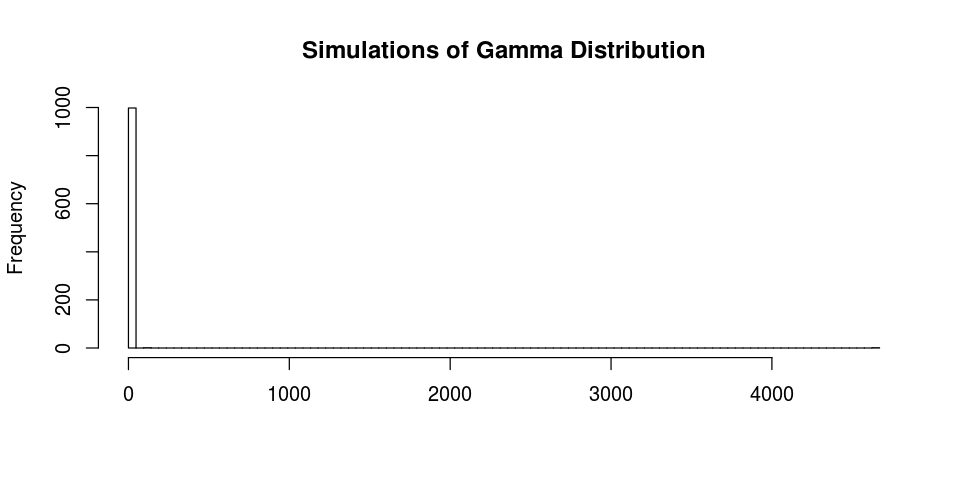

In [41]:
gamma.draws <- rgamma(1000, .001, .001)
hist(gamma.draws, main = "Simulations of Gamma Distribution", xlab = "", breaks=seq(0,max(gamma.draws),length=100))

In [42]:
summary(gamma.draws)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   0.000    0.000    0.000    4.783    0.000 4669.000 

From the summary we see that we are sampling $\tau$ near zero, but also may sample large values. 

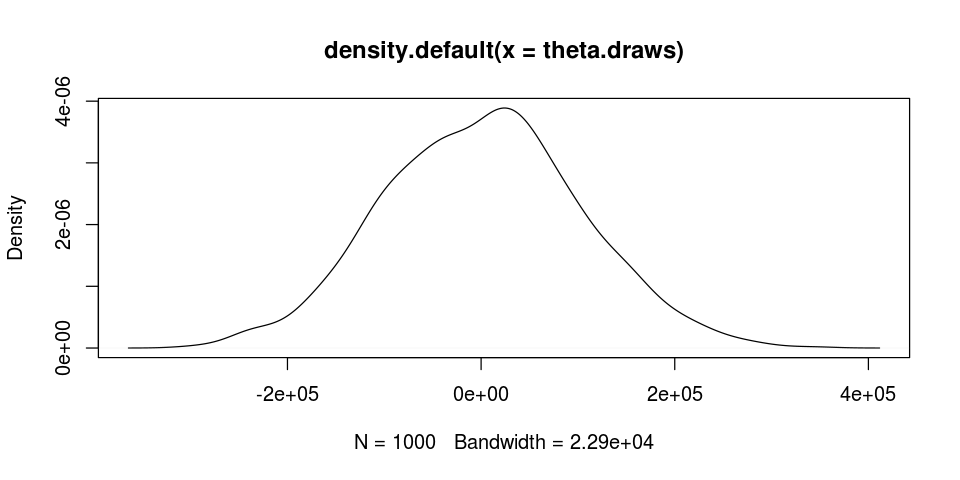

In [43]:
theta.draws <- rnorm(1000,0.0, sqrt(1/1e-10))
plot(density(theta.draws))

In [44]:

BATCHES <-
6
SAMPLES <-
5
y <-
structure(c(1545, 1540, 1595, 1445, 1595, 1520, 1440, 1555, 1550, 
1440, 1630, 1455, 1440, 1490, 1605, 1595, 1515, 1450, 1520, 1560, 
1510, 1465, 1635, 1480, 1580, 1495, 1560, 1545, 1625, 1445), .Dim = c(6, 5))

In [45]:
y

1545,1440,1440,1520,1580
1540,1555,1490,1560,1495
1595,1550,1605,1510,1560
1445,1440,1595,1465,1545
1595,1630,1515,1635,1625
1520,1455,1450,1480,1445


In [46]:
# Initialize
theta <- 1500
tau_within <- 1
tau_between <- 1
mu <- c(1500, 1500, 1500, 1500, 1500, 1500)
dyes_data <- list(theta,tau_within,tau_between, mu, BATCHES, SAMPLES, y)

## Specify the data 
<pre>
data {
    int BATCHES;
    int SAMPLES;
    real y[BATCHES, SAMPLES];
        }
</pre>


## Parameters
<pre>
parameters {
      real<lower=0> tau_between;
      real<lower=0> tau_within;
      real theta;
      real mu[BATCHES];
        }
</pre>

## Transformed parameters
```
transformed parameters {
    real sigma_between;
    real sigma_within;
     sigma_between <- 1/sqrt(tau_between);
     sigma_within <- 1/sqrt(tau_within);
        }
```

## Model 
```
model {
    theta ~ normal(0.0, 1E5);
    tau_between ~ gamma(.001, .001);
     tau_within ~ gamma(.001, .001);

  mu ~ normal(theta, sigma_between);
    for (n in 1:BATCHES)
        y[n] ~ normal(mu[n], sigma_within);
        }
```


## Generated quantities
```
generated quantities {
  real sigmasq_between;
    real sigmasq_within;
    
    sigmasq_between <- 1 / tau_between;
    sigmasq_within <- 1 / tau_within;
    }
```

In [51]:
library(rstan)
fit3 <- stan(
  file = "dyes.stan",  # Stan program
  data = dyes_data,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )

In [53]:
print(fit3, pars=c("theta", "sigmasq_within", "sigmasq_between", "mu", "lp__"), probs=c(.1,.5,.9))

Inference for Stan model: dyes.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean      sd     10%     50%     90% n_eff Rhat
theta           1527.35    0.45   21.31 1502.55 1527.35 1552.78  2208    1
sigmasq_within  2809.33   22.36  879.00 1872.41 2636.70 3982.58  1546    1
sigmasq_between 2427.15   69.95 2936.95  386.34 1591.22 5173.57  1763    1
mu[1]           1512.05    0.43   19.79 1486.93 1512.42 1536.72  2085    1
mu[2]           1527.87    0.37   19.40 1504.01 1527.64 1552.08  2759    1
mu[3]           1553.12    0.49   20.39 1527.64 1552.60 1579.74  1757    1
mu[4]           1507.01    0.41   19.81 1482.05 1506.89 1532.17  2350    1
mu[5]           1578.18    0.84   24.98 1544.08 1579.16 1609.32   882    1
mu[6]           1487.39    0.66   23.16 1457.89 1487.47 1517.55  1232    1
lp__            -158.02    0.08    2.34 -161.22 -157.65 -155.46   915    1

Samples were drawn using

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


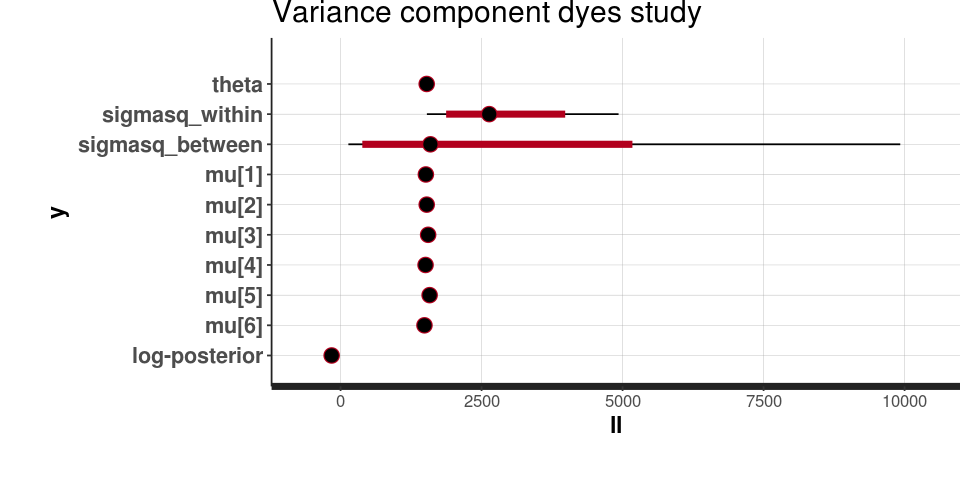

In [54]:
options(repr.plot.width=8, repr.plot.height=4)
plot(fit3,pars=c("theta", "sigmasq_within", "sigmasq_between", "mu", "lp__")) + ggtitle("Variance component dyes study") + theme(plot.margin = unit(c(0,0,1,1), "cm")) + theme(axis.text=element_text(size=10),
        axis.title=element_text(size=14,face="bold"))

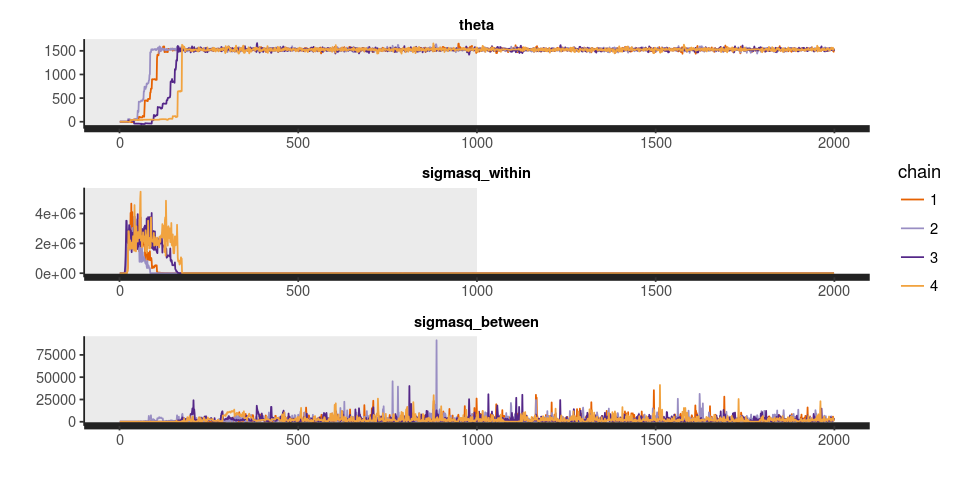

In [55]:
traceplot(fit3, pars = c("theta", "sigmasq_within","sigmasq_between"), inc_warmup = TRUE, nrow = 3)

For this run the parameter estimates are different from those obtained by Box and Tiao's estimate of $\sigma^2_{\textrm{within}} = 2451$ and $\sigma^2_{\textrm{between}} = 1764$ by the classical analysis of variance.

## Application to estimating genetic parameters : heritability (genetic variances)

We will use crop data from Holland et al. (1998) Theoretical and Applied Genetics 96:232-241 (https://www.dropbox.com/s/lkoonu7zaxy5162/CornRustData_HeritabilityVarianceComponents.xls?dl=0) to estimate heritability of resistance to southern corn rust in tropical-by-corn-belt maize populations. 

|Family	| Rust|
|------------|
|1|	7|
|1	|7|
|2	|7|
|2	|7|
|3	|5|
|3	|4|

We will apply the same variance components model used on the dyestuff dataset.  

## Model 

<center>
$y_{ij} \sim \mathcal{N}\left(\mu_i, \tau_{\textrm{within}}\right) \\ 
\mu_{i} \sim \mathcal{N}\left(\theta, \tau_{\textrm{between}}\right)
$
</center>

In [5]:
crop.data <- read.table('corn_replicates.txt',header = T)
FAMILIES <- length(unique(crop.data[,1]))
SAMPLES <-2

In [6]:
y <-t(structure(crop.data[,2], .Dim = c(SAMPLES,FAMILIES)))

In [7]:
print(y)

      [,1] [,2]
 [1,]    5    3
 [2,]    9    9
 [3,]    9    9
 [4,]    9    9
 [5,]    9    9
 [6,]    9    9
 [7,]    4    7
 [8,]    2    4
 [9,]    9    9
[10,]    7    3
[11,]    9    9
[12,]    3    3
[13,]    3    4
[14,]    4    4
[15,]    6    4
[16,]    9    9
[17,]    9    9
[18,]    3    3
[19,]    9    9
[20,]    9    9
[21,]    4    2
[22,]    9    9
[23,]    3    3
[24,]    3    3
[25,]    6    4
[26,]    9    9
[27,]    9    9
[28,]    4    5
[29,]    2    6
[30,]    9    9
[31,]    5    3
[32,]    9    9
[33,]    9    9
[34,]    9    9
[35,]    2    4
[36,]    2    3
[37,]    9    9
[38,]    9    9
[39,]    9    9
[40,]    4    4
[41,]    9    9
[42,]    9    9
[43,]    9    9
[44,]    9    9
[45,]    9    9
[46,]    9    9
[47,]    9    9
[48,]    9    9
[49,]    9    9
[50,]    2    3
[51,]    9    9
[52,]    2    4


In [8]:
# Initialize
theta <- 5
tau_within <- 1
tau_between <- 1
mu <- c(5,5)
crop_data <- list(theta,tau_within,tau_between, mu, FAMILIES, SAMPLES, y)

```
 #Dyes: variance components model
  #http://www.openbugs.net/Examples/Dyes.html

data {
    int FAMILIES;
    int SAMPLES;
    real y[FAMILIES, SAMPLES];
        }

parameters {
      real<lower=0> tau_between;
      real<lower=0> tau_within;
      real theta;
      real mu[FAMILIES];
        }

transformed parameters {
    real sigma_between;
    real sigma_within;
     sigma_between <- 1/sqrt(tau_between);
     sigma_within <- 1/sqrt(tau_within);
        }

model {
    theta ~ normal(0.0, 1E5);
    tau_between ~ gamma(.001, .001);
     tau_within ~ gamma(.001, .001);

  mu ~ normal(theta, sigma_between);
    for (n in 1:FAMILIES)
        y[n] ~ normal(mu[n], sigma_within);
        }

generated quantities {
  real sigmasq_between;
    real sigmasq_within;
    
    sigmasq_between <- 1 / tau_between;
    sigmasq_within <- 1 / tau_within;
    }
```

In [60]:
library(rstan)
fit4 <- stan(
  file = "crop.stan",  # Stan program
  data = crop_data,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )

In [61]:
print(fit4, pars=c("theta", "sigmasq_within", "sigmasq_between", "mu", "lp__"), probs=c(.1,.5,.9))

Inference for Stan model: crop.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean   sd     10%     50%     90% n_eff Rhat
theta              6.87    0.01 0.38    6.38    6.86    7.35  4000 1.00
sigmasq_within     0.78    0.00 0.16    0.59    0.75    0.99  1442 1.00
sigmasq_between    7.12    0.02 1.52    5.36    6.94    9.16  4000 1.00
mu[1]              4.16    0.01 0.60    3.39    4.15    4.93  4000 1.00
mu[2]              8.89    0.01 0.61    8.11    8.89    9.66  4000 1.00
mu[3]              8.88    0.01 0.61    8.10    8.88    9.64  4000 1.00
mu[4]              8.87    0.01 0.59    8.13    8.87    9.61  4000 1.00
mu[5]              8.89    0.01 0.59    8.13    8.88    9.62  4000 1.00
mu[6]              8.90    0.01 0.61    8.12    8.90    9.66  4000 1.00
mu[7]              5.57    0.01 0.62    4.78    5.57    6.37  4000 1.00
mu[8]              3.21    0.01 0.60    2.44    3.19    3.

The statistics reported are for replicates and the data indicates ~7% of the phenotypic variance is explained by within family membership (possibly due to measurement noise).

In [62]:
crop.data <- read.table('cornrust_heritability.txt',header = T)
FAMILIES <- length(unique(crop.data[,1]))
SAMPLES <-2

In [63]:
y <-structure(crop.data[,2], .Dim = c(FAMILIES,SAMPLES))

In [64]:
y <-t(structure(crop.data[,2], .Dim = c(SAMPLES,FAMILIES)))

In [65]:
# Initialize
theta <- 5
tau_within <- 1
tau_between <- 1
mu <- c(5,5)
crop_data <- list(theta,tau_within,tau_between, mu, FAMILIES, SAMPLES, y)

In [66]:
library(rstan)
fit5 <- stan(
  file = "crop.stan",  # Stan program
  data = crop_data,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 1000,          # number of warmup iterations per chain
  iter = 2000,            # total number of iterations per chain
  cores = 2,              # number of cores (using 2 just for the vignette)
  refresh = 1000          # show progress every 'refresh' iterations
  )

In [67]:
print(fit5, pars=c("theta", "sigmasq_within", "sigmasq_between", "mu", "lp__"), probs=c(.1,.5,.9))

Inference for Stan model: crop.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean    sd     10%     50%     90% n_eff Rhat
theta              6.83    0.00  0.15    6.63    6.83    7.02  3456    1
sigmasq_within     0.95    0.00  0.12    0.81    0.94    1.10  1387    1
sigmasq_between    2.85    0.01  0.41    2.37    2.81    3.38  2459    1
mu[1]              6.96    0.01  0.65    6.13    6.96    7.79  4000    1
mu[2]              6.98    0.01  0.64    6.16    6.99    7.80  3330    1
mu[3]              4.83    0.01  0.63    4.03    4.84    5.62  3554    1
mu[4]              6.97    0.01  0.64    6.13    6.97    7.79  3308    1
mu[5]              7.42    0.01  0.64    6.57    7.42    8.23  4000    1
mu[6]              6.99    0.01  0.64    6.15    6.99    7.80  3586    1
mu[7]              6.55    0.01  0.65    5.71    6.55    7.39  3392    1
mu[8]              8.68    0.01  0.63    7.87  

Fraction of the variance explained by within family membership is $.95/(2.84 + .95)$, which is equal to $25\%$.  

## References

1.	Gelman, A., Carlin, J. B., Stern, H. S. & Rubin, D. B. Bayesian Data Analysis, Second Edition. (CRC Press, 2003).
2.	Vidakovic, B. in Springer Texts in Statistics 733–745 (2011).
3.	Lunn, D., Jackson, C., Best, N., Thomas, A. & Spiegelhalter, D. The BUGS Book: A Practical Introduction to Bayesian Analysis. (CRC Press, 2012).
4.	Purcell, S. et al. PLINK: a tool set for whole-genome association and population-based linkage analyses. Am. J. Hum. Genet. 81, 559–575 (2007).
5.	Tiao, G. C. & Box, G. E. P. Some Comments on ‘Bayes’ Estimators. Am. Stat. 27, 12 (1973).
6.	Ward, D. H., Davies, O. L. & Goldsmith, P. L. Statistical Methods in Research and Production with Special Reference to the Chemical Industry. 4th Revised. Appl. Stat. 22, 256 (1973).
